# In this notebook we will demonstrate the general functionality of the apriltag workflow

In [2]:

from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from robotpy_apriltag import AprilTagDetector


# First, an image is loaded

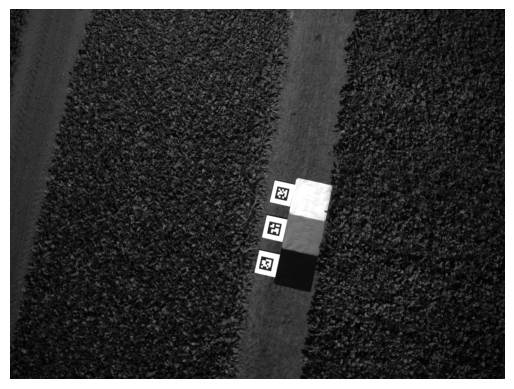

In [3]:
%matplotlib inline
path = Path("data/apriltag_example.tif")
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.axis('off')
plt.imshow(image, cmap="grey")
plt.show()

## Setting hyperparameters

In [4]:
from exiftool import ExifToolHelper

et = ExifToolHelper()

# Hyperparameters
panel_size_m = (1.4, 1.4)
width = len(image[0])
height = len(image)
resolution = (width, height)
# Tag Information
family = "tag25h9"
tag_size = 0.4


In [5]:
from reflectdetect.utils.apriltags import get_detector_config

detector = AprilTagDetector()
detector.addFamily(family)
detector.setConfig(get_detector_config())

## The detector is used to find the apriltags in the image
They have the Ids 1, 2 and 3

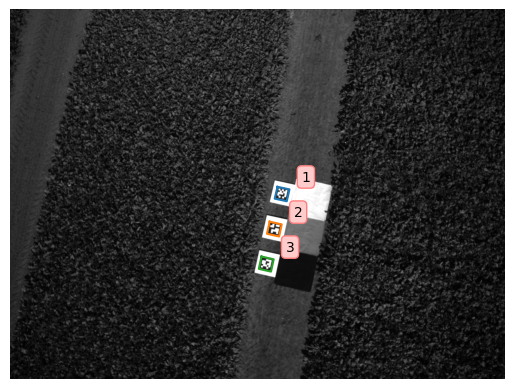

In [6]:
plt.imshow(image, cmap="gray")
plt.axis("off")
tags = detector.detect(image)
for tag in tags:
    corners = list(tag.getCorners(tuple([0.0] * 8)))
    x, y = corners[::2], corners[1::2]
    # Append the first point to the end to close the rectangle/polygon
    x = list(x) + [x[0]]
    y = list(y) + [y[0]]
    plt.plot(x, y)
    plt.text(tag.getCenter().x + 70, tag.getCenter().y - 50, tag.getId(), color="black", ha="center",
             va="center",
             bbox=dict(boxstyle="round",
                       ec=(1., 0.5, 0.5),
                       fc=(1., 0.8, 0.8),
                       ))
plt.show()

## Calculating some properties of the panels
Based on an estimated altitude and the camera properties we can calculate how big the panels should be in the image

In [7]:
from reflectdetect.utils.apriltags import get_altitude_from_tags
from reflectdetect.utils.exif import get_camera_properties
from reflectdetect.utils.panel import calculate_panel_size_in_pixels

(focal_length_mm,
 focal_plane_x_res,
 focal_plane_y_res,
 focal_plane_resolution_unit,
 ) = get_camera_properties(et, path)
altitude = get_altitude_from_tags(et, tags, path, resolution, tag_size)

tag_smudge_factor = 1.4

# Now we can use vector math to calculate the corners of the panels
Here for example we calculate the panel for tag 1. Use the sliders to change some of the hyperparameters.

In [19]:
from ipywidgets import interact, FloatSlider
from reflectdetect.utils.apriltags import tag_detection_to_total_width_conversions
from reflectdetect.utils.debug import debug_show_panels


def f(tag_smudge_factor, shrink_factor, panel_smudge_factor):
    panel_size_pixel = calculate_panel_size_in_pixels(
        altitude,
        resolution,
        panel_size_m,
        focal_length_mm,
        focal_plane_x_res,
        focal_plane_y_res,
        focal_plane_resolution_unit,
        panel_smudge_factor
    )
    tag = tags[0]
    tag_corners = np.array(
        list(tag.getCorners((0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)))
    )
    tag_corners = np.array(list((zip(tag_corners[::2], tag_corners[1::2]))))

    towards_panel = tag_corners[2] - tag_corners[1]

    tag_detection_size_pixel = np.linalg.norm(towards_panel)
    tag_size = (
            tag_detection_size_pixel
            * tag_detection_to_total_width_conversions[tag.getFamily()]
    )

    towards_panel = towards_panel / np.linalg.norm(towards_panel)

    center = np.array([tag.getCenter().x, tag.getCenter().y])
    tag_panel_border = center + towards_panel * (tag_size / 2) * tag_smudge_factor
    panel_length = towards_panel * panel_size_pixel[1]
    panel_width = towards_panel * panel_size_pixel[0]
    half_panel_width = panel_width / 2
    panel_midpoint_to_corner = [-half_panel_width[1], half_panel_width[0]]

    corner_a = tag_panel_border + panel_midpoint_to_corner
    corner_b = tag_panel_border - panel_midpoint_to_corner
    corner_c = tag_panel_border + panel_length - panel_midpoint_to_corner
    corner_d = tag_panel_border + panel_length + panel_midpoint_to_corner
    corners = [corner_a, corner_b, corner_c, corner_d]
    debug_show_panels(image, [(
        corners,
        tag,
        shrink_factor
    )])


interact(f,
         tag_smudge_factor=FloatSlider(min=0.1, max=2.0, value=1.4),
         shrink_factor=FloatSlider(min=0.1, max=1.0, value=0.8),
         panel_smudge_factor=FloatSlider(min=0.5, max=1.2, value=0.85, step=0.05), )

interactive(children=(FloatSlider(value=1.4, description='tag_smudge_factor', max=2.0, min=0.1), FloatSlider(v…

<function __main__.f(tag_smudge_factor, shrink_factor, panel_smudge_factor)>